This notebook shows how to use a **light gradient boosting model** and **day-to-day prediction** to forecast the sales on **store level**. To optimize the model I implemented a **3-fold cross-validation** taking into account the previous two month and the same month of the previous year as validation periods. I implemented a **store-WRMSSE** as validation metric, which is simply the error which the respective store contributes to the overall WRMSSE (regarding all data). Note that for this version the features and the model have not yet been opimized, so there is plenty of room for improvement.

The same code using a **neural network** instead of LGBM can be found [here](https://www.kaggle.com/dantefilu/nn-on-store-level-with-3-fold-cv-store-wrmsse).

Here are some very useful notebooks and discussions that inspired me or where I borrowed some code. Thanks a lot!

* https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda by @headsortails
* https://www.kaggle.com/nxrprime/preprocessing-fe by @nxrprime
* https://www.kaggle.com/ragnar123/very-fst-model by @ragnar123
* https://www.kaggle.com/kneroma/m5-forecast-v2-python by @kneroma
* https://www.kaggle.com/tnmasui/m5-wrmsse-evaluation-dashboard by @tnmasui
* https://www.kaggle.com/kailex/m5-forecaster-v2 by @kailex
* https://www.kaggle.com/kneroma/m5-first-public-notebook-under-0-50 by @kneroma


* https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/141515 by @amedprof
* https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/143077 by @hengck23
* https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/138881 by @kyakovlev
* https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/144067 by @kyakovlev


<a id="TOC"></a>
## Table of contents
* **1. [Set global parameters](#global)** <br>
* **2. [Import libraries and data](#Import)** <br>
* **3. [Calculate weights for WRMSSE](#WRMSSE)** <br>
* **4. [Data analysis and feature engineering](#Ana)** <br>
    * 4.1 [Sales](#Ana1) <br>
    * 4.2 [Caledar](#Ana2) <br>
    * 4.3 [Prices](#Ana3) <br>
* **5. [Data preparation for modelling](#Prep)** <br>
    * 5.1 [Merging Sales, Calendar, and Prices data sets](#Prep1) <br>
    * 5.2 [Encoding](#Prep2) <br>   
    * 5.3 [Perpare data for CV and final submission](#Prep3) <br>
* **6. [Modelling](#Model)** <br>
    * 5.1 [The Model](#Model1) <br>
    * 5.2 [Cross-validation: training and prediction](#Model2) <br>
* **7. [Conclusions](#Conclusions)** <br>



## 1. Set global parameters <a id="global"></a>



In [1]:
# target store 
STORE = 'CA_1'

# first and last days which are considered for training data
FIRST_TRAIN_DAY=600
LAST_TRAIN_DAY= 1941

# set cross validation conditions
VALID_SET_LENGTH = 28
CV_STEPS = 3

# path for data import
PATH_TO_FILE = "../input/m5-forecasting-accuracy"

[back to Table of Contents](#TOC)
## 2. Import libraries and data <a id="Import"></a>

In [2]:
import pandas as pd
import numpy as np
import gc
import os
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

import lightgbm as lgb


In [3]:
# credit to https://www.kaggle.com/ragnar123/very-fst-model
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df.loc[:,col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df.loc[:,col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df.loc[:,col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df.loc[:,col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df.loc[:,col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df.loc[:,col] = df[col].astype(np.float32)
                else:
                    df.loc[:,col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df  


In [4]:
def load_sales_data(path=PATH_TO_FILE):
    print('Load sales data ...')
    sales_all = pd.read_csv(os.path.join(path, "sales_train_evaluation.csv"))
    sales=sales_all[sales_all.store_id==STORE].copy()
    return sales, sales_all

def load_calendar_data(path=PATH_TO_FILE):
    print('Load calendar data ...')
    calendar_all = pd.read_csv(os.path.join(path, "calendar.csv"))
    if 'CA' in STORE:
        calendar=calendar_all.drop(['snap_TX','snap_WI'], axis=1)    
    elif 'TX' in STORE:
        calendar=calendar_all.drop(['snap_CA','snap_WI'], axis=1) 
    elif 'WI' in STORE:
        calendar=calendar_all.drop(['snap_CA','snap_TX'], axis=1)
    return calendar, calendar_all


def load_price_data(path=PATH_TO_FILE):
    print('Load price data ...')
    prices_all = pd.read_csv(os.path.join(path, "sell_prices.csv"))
    prices=prices_all[prices_all.store_id==STORE]
    return prices, prices_all


In [5]:
%%time
# load all data
sales, sales_all = load_sales_data()
calendar, calendar_all = load_calendar_data()
prices, prices_all = load_price_data()

# data needed for evaluation process
sample_submission = pd.read_csv(os.path.join(PATH_TO_FILE, "sample_submission.csv"))
sales_copy = sales.copy()

Load sales data ...
Load calendar data ...
Load price data ...
CPU times: user 11.5 s, sys: 1.91 s, total: 13.4 s
Wall time: 13.5 s


[back to Table of Contents](#TOC)
## 3. Calculate weights for WRMSSE <a id="WRMSSE"></a>

Credit mainly goes to https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834 and https://www.kaggle.com/tnmasui/m5-wrmsse-evaluation-dashboard

In [6]:
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 'all'  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')]\
                     .columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')]\
                               .columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], 
                                 axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)\
                    [valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns]\
                    .set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index()\
                   .rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left',
                                    on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd'])\
                    .unstack(level=2)['value']\
                    .loc[zip(self.train_df.item_id, self.train_df.store_id), :]\
                    .reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns],
                               weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt) 
    
    def score(self, valid_preds: Union[pd.DataFrame, 
                                       np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape \
               == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, 
                                       columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], 
                                 valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):

            valid_preds_grp = valid_preds.groupby(group_id)[self.valid_target_columns].sum()
            setattr(self, f'lv{i + 1}_valid_preds', valid_preds_grp)
            
            lv_scores = self.rmsse(valid_preds_grp, i + 1)
            setattr(self, f'lv{i + 1}_scores', lv_scores)
            
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, 
                                  sort=False).prod(axis=1)
            
            all_scores.append(lv_scores.sum())
            
        self.all_scores = all_scores

        return np.mean(all_scores)

In [7]:
def prepare_store_prediction_for_WRMSSE_dashboard(pred, sales_all=sales_all): 
    # prepare template with ground truth according to validation step
    sub = sales_all[['id']+[f'd_{d}' for d in range(pred.d.min(), pred.d.max()+1)]]
    sub = sub[sub.id.str.endswith('_evaluation')].copy()
    sub = sub.set_index(['id'])

    # transfom prediction df for score evaluation
    pred = pred.assign(id=pred.id, d_="d_" + (pred.d).astype("str"))
    pred = pred.pivot(index='id', columns="d_", values="sales")

    # update respective store with predicted values
    sub.update(pred)

    # reindex
    new_index=sales_all[['id','item_id','store_id']].copy()
    sub = sub.reset_index().merge(new_index, how='left', on=['id']).set_index(['item_id','store_id'])
    sub = sub.drop(['id'], axis=1)

    return sub

In [8]:
%%time
WRMSSE_evaluators = {}
for CV_step in range(1,CV_STEPS+1):
    print(f'Build WRMSSE_evaluator for CV step {CV_step} ...')
    
    # define last CV step: same 28 days as for prediction period but of the previous year
    CV_start = FIRST_TRAIN_DAY
    if CV_step == CV_STEPS:
        CV_end = LAST_TRAIN_DAY - 364 + VALID_SET_LENGTH   
    else:
        CV_end = LAST_TRAIN_DAY - (CV_step-1)*VALID_SET_LENGTH 
        
    print(f'validation start day: {CV_end-VALID_SET_LENGTH+1}')
    print(f'validation end day: {CV_end}')
    
    # prepare train and valid data for current CV step
    train_df = sales_all.drop([f'd_{i}' for i in range(1,CV_start)]
                              +[f'd_{i}' for i in range(CV_end - VALID_SET_LENGTH +1,LAST_TRAIN_DAY+1)], axis=1)
    #train_df = train_df.drop([f'd_{i}' for i in range(CV_train_end,LAST_TRAIN_DAY)], axis=1)
    valid_df = sales_all[[f'd_{i}' for i in range(CV_end - VALID_SET_LENGTH +1,CV_end +1)]]
    
    # prepare calendar for current CV step
    calendar_n = calendar_all.iloc[ CV_start-1 : CV_end, : ]

    # prepare prices for current CV step
    prices_start = calendar_all['wm_yr_wk'][CV_start-1]
    prices_end = calendar_all['wm_yr_wk'][CV_end-1]
    prices_n = prices_all.loc[(prices_all.wm_yr_wk>=prices_start) & (prices_all.wm_yr_wk<=prices_end), :]
    
    # inizialize WRMSSE_evaluator objects for current CV step
    WRMSSE_evaluators[f'eval_CV_{CV_step}'] = WRMSSEEvaluator(train_df, valid_df, calendar_n, prices_n)

Build WRMSSE_evaluator for CV step 1 ...
validation start day: 1914
validation end day: 1941



Build WRMSSE_evaluator for CV step 2 ...
validation start day: 1886
validation end day: 1913



Build WRMSSE_evaluator for CV step 3 ...
validation start day: 1578
validation end day: 1605


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



CPU times: user 52.4 s, sys: 11.5 s, total: 1min 3s
Wall time: 1min 3s


In [9]:
# visualization of WRMSSE

def create_viz_df(df,lv):
    
    df = df.T.reset_index()
    if lv in [6,7,8,9,11,12]:
        df.columns = [i[0] + '_' + i[1] if i != ('index','') \
                      else i[0] for i in df.columns]
    df = df.merge(calendar_all.loc[:, ['d','date']], how='left', 
                  left_on='index', right_on='d')
    df['date'] = pd.to_datetime(df.date)
    df = df.set_index('date')
    df = df.drop(['index', 'd'], axis=1)
    
    return df

def create_dashboard(CV_step):
    
    evaluator = WRMSSE_evaluators[f'eval_CV_{CV_step}']
    wrmsses = [np.mean(evaluator.all_scores)] + evaluator.all_scores
    labels = ['Overall'] + [f'Level {i}' for i in range(1, 13)]

    
        
    # configuration array for the charts
    n_rows = [1, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3]
    n_cols = [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
    width = [7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
    height = [4, 3, 12, 3, 9, 9, 9, 9, 9, 9, 9, 9]
    
    for i in [3,8]:
        
        scores = getattr(evaluator, f'lv{i}_scores')
        weights = getattr(evaluator, f'lv{i}_weight')
        
        if i > 1 and i < 9:
            if i < 7:
                fig, axs = plt.subplots(1, 2, figsize=(12, 3))
            else:
                fig, axs = plt.subplots(2, 1, figsize=(12, 8))
                
            ## RMSSE plot
            scores.plot.bar(width=.8, ax=axs[0], color='g')
            axs[0].set_title(f"RMSSE", size=14)
            axs[0].set(xlabel='', ylabel='RMSSE')
            if i >= 4:
                axs[0].tick_params(labelsize=8)
            for index, val in enumerate(scores):
                axs[0].text(index*1, val+.01, round(val,4), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
            
            ## Weight plot
            weights.plot.bar(width=.8, ax=axs[1])
            axs[1].set_title(f"Weight", size=14)
            axs[1].set(xlabel='', ylabel='Weight')
            if i >= 4:
                axs[1].tick_params(labelsize=8)
            for index, val in enumerate(weights):
                axs[1].text(index*1, val+.01, round(val,2), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
                    
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 ,
                         y=1.1, fontweight='bold')
            plt.tight_layout()
            plt.show()

    # PLOT SALES
    # actual data
    sales_cum= data[(data.d<=data_val[f'CV_{CV_step}'].d.max())&(data.d>=data_val[f'CV_{CV_step}'].d.max()-60)].groupby('d')['sales'].sum()

    # NN prediction 
    sales_cum_NN_pred = data_val[f'CV_{CV_step}'].groupby('d')['sales'].sum()

    ##seasonal naive baseline
    #shift=364
    #sales_cum_baseline = data[(data.d<=data_val[f'CV_{CV_step}'].d.max()-shift)&(data.d>data_val[f'CV_{CV_step}'].d.max()-shift-VALID_SET_LENGTH)].groupby('d')['sales'].sum()
    #sales_cum_baseline.index = sales_cum_baseline.index +shift

    polt = sales_cum.plot(x ='d', y='sales', kind = 'line',figsize=(16,8), label='actual sales')
    polt = sales_cum_NN_pred.plot(x ='d', y='sales', kind = 'line',figsize=(16,8), label='predicted sales: NN')
    #polt = sales_cum_baseline.plot(x ='d', y='sales', kind = 'line',figsize=(16,8), label='predicted sales: seasonal naive')
    plt.legend(loc="upper left")
    plt.title(f'All sales for store {STORE}')
    plt.show()


[back to Table of Contents](#TOC)
## 4. Data analysis and feature engineering <a id="Ana"></a>

### 4.1 Sales data <a id="Ana1"></a>

In [10]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [11]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3049 entries, 0 to 3048
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 45.3+ MB


In [12]:
def prepare_sales_data(df, first_train_day=FIRST_TRAIN_DAY):
    
    # select rows for selected store
    df = df.drop(['state_id', 'store_id'], axis=1)
    
    # add day columns for test data - this way both train and test data are prepared together
    last_train_day = int(df.columns[-1].replace('d_',''))
    for day in range(last_train_day+1, last_train_day+ 28 +1):
        df[f"d_{day}"] = np.nan
    
    # reshape sales days 'd_XXXX' from wide to long format.
    if first_train_day != None:
        df = df.drop(["d_" + str(i + 1) for i in range(first_train_day)], axis=1).copy()
    id_vars = [col for col in df.columns if not col.startswith("d_")]
    df = df.melt(id_vars = id_vars, var_name = "d", value_name = "sales")
    
    # convert feature 'd' to integer
    df = df.assign(d=df.d.str[2:].astype("int16"))
    
    # reduce data size
    df = reduce_memory_usage(df)
    
    return df


In [13]:
sales = prepare_sales_data(sales)
gc.collect()
sales.head()

Mem. usage decreased to 143.31 Mb (14.3% reduction)


,id,item_id,dept_id,cat_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,601,0.0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,601,0.0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,601,0.0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,601,1.0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,601,2.0


In [14]:
                                                                             
def create_sales_features(df, params):
    if params['activate']:
        lag = params['lag']
        print(f'shift_lag: {lag}')
        if params['lag_feature'] == True:
            df.loc[:,f'lag_l{lag}'] = df.groupby(['id'])['sales'].transform(lambda x: x.shift(lag))
        if params['roll_mean_win'] != []:
            for win in params['roll_mean_win']:
                print(f'rolling_mean: {lag}/{win}')                                                                       
                df[f'rolling_mean_l{lag}_w{win}'] = df.groupby(['id'])['sales'].transform(lambda x: x.shift(lag).rolling(win).mean())
        if params['roll_median_win'] != []:
            for win in params['roll_median_win']:
                print(f'rolling_median: {lag}/{win}')                                                                       
                df[f'rolling_median_l{lag}_w{win}'] = df.groupby(['id'])['sales'].transform(lambda x: x.shift(lag).rolling(win).median())
        if params['roll_std_win'] != []:
            for win in params['roll_std_win']:
                print(f'rolling_std: {lag}/{win}')                                                                       
                df[f'rolling_std_l{lag}_w{win}'] = df.groupby(['id'])['sales'].transform(lambda x: x.shift(lag).rolling(win).std())
    return df   

In the following cell you can set the parameters for the sales features: 
Select **'activate': True** to use the respective lag feature and fill the list with whatever windows you want to use. If the list is empty, it will not be used.
The code below allows to easily try a lot of different lag features and always be sure that the missing values are calculated in the day-to-day prediction for lags smaller than 28 days (more infos on this issue [here](https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/141515))

In [15]:
# set parameters for sales features and activate for use

params_lag7 = {'activate': True,
               'lag': 7,
               'lag_feature':True,
               'roll_mean_win':[7],
               'roll_median_win':[7],
               'roll_std_win':[7]}

params_lag14 = {'activate': False,
               'lag': 14,
               'lag_feature':True,
               'roll_mean_win':[7],
               'roll_median_win':[7],
               'roll_std_win':[7]}

params_lag21 = {'activate': False,
               'lag': 21,
               'lag_feature':True,
               'roll_mean_win':[7],
               'roll_median_win':[7],
               'roll_std_win':[7]}

params_lag28 = {'activate': True,
               'lag': 28,
               'lag_feature':True,
               'roll_mean_win':[7,28],
               'roll_median_win':[7,28],
               'roll_std_win':[7,28]}

params_lag182 = {'activate': False,
               'lag': 182,
               'lag_feature':True,
               'roll_mean_win':[28],
               'roll_median_win':[],
               'roll_std_win':[]}

params_lag364 = {'activate': False,
               'lag': 364,
               'lag_feature':True,
               'roll_mean_win':[7,28],
               'roll_median_win':[],
               'roll_std_win':[]}


# create features
sales = create_sales_features(sales, params_lag7)
sales = create_sales_features(sales, params_lag14)
sales = create_sales_features(sales, params_lag21)
sales = create_sales_features(sales, params_lag28)
sales = create_sales_features(sales, params_lag182)
sales = create_sales_features(sales, params_lag364)



shift_lag: 7
rolling_mean: 7/7
rolling_median: 7/7
rolling_std: 7/7
shift_lag: 28
rolling_mean: 28/7
rolling_mean: 28/28
rolling_median: 28/7
rolling_median: 28/28
rolling_std: 28/7
rolling_std: 28/28


In [16]:
def return_df_with_lag_and_win_per_column(df):
    df_shift = pd.DataFrame({'lag+win': [0 for col in df.columns]}, index = df.columns)
    for col in df.columns:
        if '_l' in col:
            pre = col.split('_l')[1]
            if '_w' in pre:
                lag = int(pre.split('_w')[0])
                win = int(pre.split('_w')[1])             
                total = lag + win
            else: 
                lag = int(pre)
                win = 0
                total = lag
            df_shift.loc[col, 'lag'] = lag
            df_shift.loc[col, 'win'] = win
            df_shift.loc[col, 'lag+win'] = total
    return df_shift.loc[df_shift['lag+win']!=0]
        

In [17]:
# remove rows where NaNs originate from feature engineering
mask = (return_df_with_lag_and_win_per_column(sales)['lag+win']).idxmax()
sales = sales[(sales.d >= 1914) | (pd.notna(sales[mask]))].copy()



In [18]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4006386 entries, 167695 to 4174080
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   id                      object 
 1   item_id                 object 
 2   dept_id                 object 
 3   cat_id                  object 
 4   d                       int16  
 5   sales                   float16
 6   lag_l7                  float16
 7   rolling_mean_l7_w7      float16
 8   rolling_median_l7_w7    float16
 9   rolling_std_l7_w7       float16
 10  lag_l28                 float16
 11  rolling_mean_l28_w7     float16
 12  rolling_mean_l28_w28    float16
 13  rolling_median_l28_w7   float16
 14  rolling_median_l28_w28  float16
 15  rolling_std_l28_w7      float16
 16  rolling_std_l28_w28     float16
dtypes: float16(12), int16(1), object(4)
memory usage: 252.2+ MB


### 4.2 Calendar data <a id="Ana2"></a>

In [19]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1


In [20]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
dtypes: int64(5), object(7)
memory usage: 184.7+ KB


In [21]:
def prepare_calendar_data(df):
    #drop further useless features  
    df = df.drop(['date', 'weekday'], axis=1)
    
    # convert feature 'd' to integer
    df = df.assign(d = df.d.str[2:].astype(int))
    
    # substitute NaN in event_name and event_type by 'undefined'
    df = df.fillna('undefined')
    
    # reduce data size
    df = reduce_memory_usage(df)
    
    return df

In [22]:
calendar = prepare_calendar_data(calendar)
gc.collect()
calendar.head()

Mem. usage decreased to  0.08 Mb (48.7% reduction)


,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA
0,11101,1,1,2011,1,undefined,undefined,undefined,undefined,0
1,11101,2,1,2011,2,undefined,undefined,undefined,undefined,0
2,11101,3,1,2011,3,undefined,undefined,undefined,undefined,0
3,11101,4,2,2011,4,undefined,undefined,undefined,undefined,1
4,11101,5,2,2011,5,undefined,undefined,undefined,undefined,1


In [23]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   wm_yr_wk      1969 non-null   int16 
 1   wday          1969 non-null   int8  
 2   month         1969 non-null   int8  
 3   year          1969 non-null   int16 
 4   d             1969 non-null   int16 
 5   event_name_1  1969 non-null   object
 6   event_type_1  1969 non-null   object
 7   event_name_2  1969 non-null   object
 8   event_type_2  1969 non-null   object
 9   snap_CA       1969 non-null   int8  
dtypes: int16(3), int8(3), object(4)
memory usage: 79.0+ KB


### 4.3 Price data <a id="Ana3"></a>

In [24]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [25]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 698412 entries, 0 to 698411
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   store_id    698412 non-null  object 
 1   item_id     698412 non-null  object 
 2   wm_yr_wk    698412 non-null  int64  
 3   sell_price  698412 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 26.6+ MB


In [26]:
def prepare_price_data(df):
    #drop useless features  
    df = df.drop(['store_id'], axis=1)
    
    # reduce data size
    df = reduce_memory_usage(df)
    
    return df

In [27]:
prices = prepare_price_data(prices)

Mem. usage decreased to 13.32 Mb (37.5% reduction)


In [28]:
prices.sell_price.isnull().value_counts()

False    698412
Name: sell_price, dtype: int64

In [29]:
def create_price_features(df):
    
    # percentage change between the current and a prior element
    df["sell_price_rel_diff"] = df.groupby(["item_id"])["sell_price"].pct_change()
    
    # rolling std of prices
    df["sell_price_roll_sd7"] = df.groupby(["item_id"])["sell_price"].transform(lambda x: x.rolling(7).std())
    
    # relative cumulative price 
    grouped = df.groupby(["item_id"])["sell_price"]
    df["sell_price_cumrel"] = (grouped.shift(0) - grouped.cummin()) / (1 + grouped.cummax() - grouped.cummin())
    
    # reduce data size
    df = reduce_memory_usage(df)
    
    return df


In [30]:
#create new price features
prices = create_price_features(prices)

Mem. usage decreased to 17.32 Mb (0.0% reduction)


In [31]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 698412 entries, 0 to 698411
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   item_id              698412 non-null  object 
 1   wm_yr_wk             698412 non-null  int16  
 2   sell_price           698412 non-null  float16
 3   sell_price_rel_diff  695363 non-null  float16
 4   sell_price_roll_sd7  680118 non-null  float16
 5   sell_price_cumrel    698412 non-null  float16
dtypes: float16(4), int16(1), object(1)
memory usage: 17.3+ MB


[back to Table of Contents](#TOC)
## 5. Data preparation for modeling <a id="Prep"></a>

### 5.1 Merge Sales, calendar and prices data sets <a id='Prep1'></a>

In [32]:
data = sales.merge(calendar, how="left", on="d")
data = data.merge(prices, how="left", on=["wm_yr_wk", "item_id"])
data.drop(["wm_yr_wk"], axis=1, inplace=True)
del sales, calendar, prices
gc.collect()
data.head()

,id,item_id,dept_id,cat_id,d,sales,lag_l7,rolling_mean_l7_w7,rolling_median_l7_w7,rolling_std_l7_w7,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,656,0.0,0.0,0.000000,0.0,0.000000,...,2012,undefined,undefined,undefined,undefined,0,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,656,0.0,0.0,0.000000,0.0,0.000000,...,2012,undefined,undefined,undefined,undefined,0,3.970703,0.0,0.0,0.000000
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,656,0.0,0.0,0.000000,0.0,0.000000,...,2012,undefined,undefined,undefined,undefined,0,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,656,0.0,0.0,0.856934,0.0,1.463867,...,2012,undefined,undefined,undefined,undefined,0,4.339844,0.0,0.0,0.000000
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,656,0.0,0.0,1.286133,1.0,1.112305,...,2012,undefined,undefined,undefined,undefined,0,2.980469,0.0,0.0,0.333252


In [33]:
data

,id,item_id,dept_id,cat_id,d,sales,lag_l7,rolling_mean_l7_w7,rolling_median_l7_w7,rolling_std_l7_w7,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,656,0.0,0.0,0.000000,0.0,0.000000,...,2012,undefined,undefined,undefined,undefined,0,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,656,0.0,0.0,0.000000,0.0,0.000000,...,2012,undefined,undefined,undefined,undefined,0,3.970703,0.0,0.0,0.000000
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,656,0.0,0.0,0.000000,0.0,0.000000,...,2012,undefined,undefined,undefined,undefined,0,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,656,0.0,0.0,0.856934,0.0,1.463867,...,2012,undefined,undefined,undefined,undefined,0,4.339844,0.0,0.0,0.000000
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,656,0.0,0.0,1.286133,1.0,1.112305,...,2012,undefined,undefined,undefined,undefined,0,2.980469,0.0,0.0,0.333252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4006381,FOODS_3_823_CA_1_evaluation,FOODS_3_823,FOODS_3,FOODS,1969,NaN,NaN,NaN,NaN,NaN,...,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,2.980469,0.0,0.0,0.333252
4006382,FOODS_3_824_CA_1_evaluation,FOODS_3_824,FOODS_3,FOODS,1969,NaN,NaN,NaN,NaN,NaN,...,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,2.480469,0.0,0.0,0.008080
4006383,FOODS_3_825_CA_1_evaluation,FOODS_3_825,FOODS_3,FOODS,1969,NaN,NaN,NaN,NaN,NaN,...,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,3.980469,0.0,0.0,0.000000
4006384,FOODS_3_826_CA_1_evaluation,FOODS_3_826,FOODS_3,FOODS,1969,NaN,NaN,NaN,NaN,NaN,...,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1.280273,0.0,0.0,0.000000


### 5.2 Encoding <a id='Prep2'></a>

In [34]:
cat_features = ["item_id", "dept_id", "cat_id",  
                'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', f"snap_{STORE.split('_')[0]}"]
num_features = [e for e in data.columns if e not in cat_features + ['sales','id']] + ['d']


# encode numerical features 
for i, feature in enumerate(num_features):
    data[feature] = data[feature].fillna(data[feature].median())
    

# encode categorical features
for i, feature in enumerate(cat_features):
    data[feature] = OrdinalEncoder(dtype="int").fit_transform(data[[feature]])


In [35]:
data

,id,item_id,dept_id,cat_id,d,sales,lag_l7,rolling_mean_l7_w7,rolling_median_l7_w7,rolling_std_l7_w7,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1_evaluation,1437,3,1,656,0.0,0.0,0.000000,0.0,0.000000,...,2012,30,4,3,2,0,3.470703,0.0,0.0,0.000000
1,HOBBIES_1_002_CA_1_evaluation,1438,3,1,656,0.0,0.0,0.000000,0.0,0.000000,...,2012,30,4,3,2,0,3.970703,0.0,0.0,0.000000
2,HOBBIES_1_003_CA_1_evaluation,1439,3,1,656,0.0,0.0,0.000000,0.0,0.000000,...,2012,30,4,3,2,0,3.470703,0.0,0.0,0.000000
3,HOBBIES_1_004_CA_1_evaluation,1440,3,1,656,0.0,0.0,0.856934,0.0,1.463867,...,2012,30,4,3,2,0,4.339844,0.0,0.0,0.000000
4,HOBBIES_1_005_CA_1_evaluation,1441,3,1,656,0.0,0.0,1.286133,1.0,1.112305,...,2012,30,4,3,2,0,2.980469,0.0,0.0,0.333252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4006381,FOODS_3_823_CA_1_evaluation,1432,2,0,1969,NaN,0.0,0.571289,0.0,0.755859,...,2016,16,3,1,0,0,2.980469,0.0,0.0,0.333252
4006382,FOODS_3_824_CA_1_evaluation,1433,2,0,1969,NaN,0.0,0.571289,0.0,0.755859,...,2016,16,3,1,0,0,2.480469,0.0,0.0,0.008080
4006383,FOODS_3_825_CA_1_evaluation,1434,2,0,1969,NaN,0.0,0.571289,0.0,0.755859,...,2016,16,3,1,0,0,3.980469,0.0,0.0,0.000000
4006384,FOODS_3_826_CA_1_evaluation,1435,2,0,1969,NaN,0.0,0.571289,0.0,0.755859,...,2016,16,3,1,0,0,1.280273,0.0,0.0,0.000000


### 5.3 Prepare data for cross-validation and final submission <a id='Prep3'></a>

In [36]:
def check_number_of_rows_with_NaNs(df, column='', last_train_day=LAST_TRAIN_DAY):
    if column == '':
        NaN_rows_all = len(df[(df.d<=last_train_day) & df.isna().any(axis=1)])
        print('rows containing NaN values: '+ str(NaN_rows_all))
    else:
        NaN_rows_all = len(df[(df.d<=last_train_day) & df.isna().any(axis=1)])
        NaN_rows_col = len(df[(df.d<=last_train_day) & df[column].isna()])
        print('rows containing NaN values (column/total): '+ str(NaN_rows_col)+'/'+ str(NaN_rows_all))
        
check_number_of_rows_with_NaNs(data)

rows containing NaN values: 0


In [37]:
def prepare_data_for_current_validation_step(data, current_CV_step):
    # determine column with max number of NaN caused by lag features
    df_lag_win = return_df_with_lag_and_win_per_column(data)
    max_NaN_rows = max(df_lag_win['lag+win'])
        
    # determin start and end days of training and validation data for current validation step
    if current_CV_step == CV_STEPS: 
        first_day = LAST_TRAIN_DAY - max_NaN_rows - 364 -1
        last_day = LAST_TRAIN_DAY + VALID_SET_LENGTH - 364
        pred_start_day =  last_day - VALID_SET_LENGTH +1
    else:
        first_day = LAST_TRAIN_DAY - current_CV_step*VALID_SET_LENGTH - max_NaN_rows -1
        last_day = LAST_TRAIN_DAY - (current_CV_step-1)*VALID_SET_LENGTH
        pred_start_day =  last_day - VALID_SET_LENGTH +1
   
    print(first_day)
    print(f'Validation range: {pred_start_day} - {last_day}\n')
    print('Prepare data ...\n')

    # prepare training data
    mask = data.d < pred_start_day
    X_train = data[cat_features + num_features][mask]
    y_train = data["sales"][mask]
    train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_features, free_raw_data=False)
    
    # prepare validation data for model
    mask = (data.d >= pred_start_day) & (data.d <= last_day) 
    X_valid = data[cat_features + num_features][mask]
    y_valid = data["sales"][mask]
    valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=cat_features, free_raw_data=False)#

   # prepare validation data for realistic day-to-day prediction (to avoid data leakage)  
    df_val = data[(data.d >= first_day) & (data.d <= last_day)].copy()
    df_val.loc[df_val.d >= pred_start_day, 'sales']=0
    for col, lag in df_lag_win.lag.items():   
        df_val.loc[df_val.d > pred_start_day + lag, col]=0

    return train_data, valid_data, df_val

In [38]:
gc.collect()

20

[back to Table of Contents](#TOC)
## 6. Modeling <a id='Model'></a>

### 6.1 The Model <a id='Model1'></a>

In [39]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        "metric": ["rmse"],
        'verbosity': 1,
        'num_iterations' : 200,
        'num_leaves': 128,
        "min_data_in_leaf": 100}

Parameters also see https://www.kaggle.com/kailex/m5-forecaster-v2 and https://www.kaggle.com/kneroma/m5-first-public-notebook-under-0-50.

### 6.2 Cross-validatoion: Training and prediction <a id='Model2'></a>

In [40]:

def predict_validation_data_for_current_validation_step(data, current_CV_step):
    
    # prepare data
    train_data, valid_data, data_val = prepare_data_for_current_validation_step(data, current_CV_step)


    # train model
    print('Train model ...\n')
    m_lgb = lgb.train(params, train_data, valid_sets = [valid_data], verbose_eval=20) 


    # day-by-day prediction
    print('\n Predict validation data ...\n')
    lag = 7 # min lag used for features
    interval = 1

    if current_CV_step == CV_STEPS: 
        start_day = LAST_TRAIN_DAY -364 +1
    else:
        start_day = LAST_TRAIN_DAY - current_CV_step*VALID_SET_LENGTH +1

    for i in range(start_day, data_val.d.max() +1):
        print(i)
        if i== start_day + interval*lag:
            data_val = create_sales_features(data_val, params_lag7)
            interval+=1  
        if i== start_day + 2*lag:
            data_val = create_sales_features(data_val, params_lag14)
        if i== start_day + 3*lag:
            data_val = create_sales_features(data_val, params_lag21)

        X = data_val[cat_features + num_features][data_val.d == i] 
        y_pred =  1.03 * m_lgb.predict(X)
        
        data_val.loc[data_val.d == i, "sales"] = y_pred 
    
    print('\n')
    
    # calculate store-WRMSSE for CV step
    pred = prepare_store_prediction_for_WRMSSE_dashboard(data_val[data_val.d>=start_day]).values
    W = WRMSSE_evaluators[f'eval_CV_{current_CV_step}'].score(pred) 
    print(f'store-WRMSSE for CV_{current_CV_step}: ' + str(W)+'\n\n\n')
    
    print('\n')
    
    return data_val[data_val.d>=start_day], [W]


In [41]:
%%time
data_val={}
CV_scores=pd.DataFrame()

for CV_step in range(1,CV_STEPS+1):
    print(f'VALIDATION STEP {CV_step}\n')
    
    # training and prediction for CV step
    data_val[f'CV_{CV_step}'], CV_scores[f'{STORE}_CV{CV_step}'] = predict_validation_data_for_current_validation_step(data,CV_step)
    

VALIDATION STEP 1

1856
Validation range: 1914 - 1941

Prepare data ...

Train model ...



/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid_0's rmse: 2.51322
[40]	valid_0's rmse: 2.22695
[60]	valid_0's rmse: 2.154
[80]	valid_0's rmse: 2.13554
[100]	valid_0's rmse: 2.12797
[120]	valid_0's rmse: 2.12613
[140]	valid_0's rmse: 2.12567
[160]	valid_0's rmse: 2.12349
[180]	valid_0's rmse: 2.12252
[200]	valid_0's rmse: 2.12111

 Predict validation data ...

1914
1915
1916
1917
1918
1919
1920
1921
shift_lag: 7
rolling_mean: 7/7
rolling_median: 7/7
rolling_std: 7/7
1922
1923
1924
1925
1926
1927
1928
shift_lag: 7
rolling_mean: 7/7
rolling_median: 7/7
rolling_std: 7/7
1929
1930
1931
1932
1933
1934
1935
shift_lag: 7
rolling_mean: 7/7
rolling_median: 7/7
rolling_std: 7/7
1936
1937
1938
1939
1940
1941


store-WRMSSE for CV_1: 0.07741049638302434





VALIDATION STEP 2

1828
Validation range: 1886 - 1913

Prepare data ...

Train model ...



/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid_0's rmse: 2.4314
[40]	valid_0's rmse: 2.17576
[60]	valid_0's rmse: 2.12057
[80]	valid_0's rmse: 2.10906
[100]	valid_0's rmse: 2.10818
[120]	valid_0's rmse: 2.10876
[140]	valid_0's rmse: 2.10837
[160]	valid_0's rmse: 2.10797
[180]	valid_0's rmse: 2.11189
[200]	valid_0's rmse: 2.11166

 Predict validation data ...

1886
1887
1888
1889
1890
1891
1892
1893
shift_lag: 7
rolling_mean: 7/7
rolling_median: 7/7
rolling_std: 7/7
1894
1895
1896
1897
1898
1899
1900
shift_lag: 7
rolling_mean: 7/7
rolling_median: 7/7
rolling_std: 7/7
1901
1902
1903
1904
1905
1906
1907
shift_lag: 7
rolling_mean: 7/7
rolling_median: 7/7
rolling_std: 7/7
1908
1909
1910
1911
1912
1913


store-WRMSSE for CV_2: 0.10694015090708257





VALIDATION STEP 3

1520
Validation range: 1578 - 1605

Prepare data ...

Train model ...



/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid_0's rmse: 2.62662
[40]	valid_0's rmse: 2.31864
[60]	valid_0's rmse: 2.23804
[80]	valid_0's rmse: 2.21795
[100]	valid_0's rmse: 2.20823
[120]	valid_0's rmse: 2.20235
[140]	valid_0's rmse: 2.2007
[160]	valid_0's rmse: 2.19892
[180]	valid_0's rmse: 2.1964
[200]	valid_0's rmse: 2.19426

 Predict validation data ...

1578
1579
1580
1581
1582
1583
1584
1585
shift_lag: 7
rolling_mean: 7/7
rolling_median: 7/7
rolling_std: 7/7
1586
1587
1588
1589
1590
1591
1592
shift_lag: 7
rolling_mean: 7/7
rolling_median: 7/7
rolling_std: 7/7
1593
1594
1595
1596
1597
1598
1599
shift_lag: 7
rolling_mean: 7/7
rolling_median: 7/7
rolling_std: 7/7
1600
1601
1602
1603
1604
1605


store-WRMSSE for CV_3: 0.0873081295473641





CPU times: user 40min 14s, sys: 16.3 s, total: 40min 31s
Wall time: 11min 49s


In [42]:
# show store-WRMSSE of the different CV steps (store-WRMSSE is the contribution of the respective store to the total/final WRMSSE)
CV_scores[f'{STORE}_CV_mean'] = CV_scores.loc[0,:].mean()
CV_scores.to_csv(f"wrmsse_{STORE}.csv", index=True)
CV_scores

,CA_1_CV1,CA_1_CV2,CA_1_CV3,CA_1_CV_mean
0,0.07741,0.10694,0.087308,0.090553


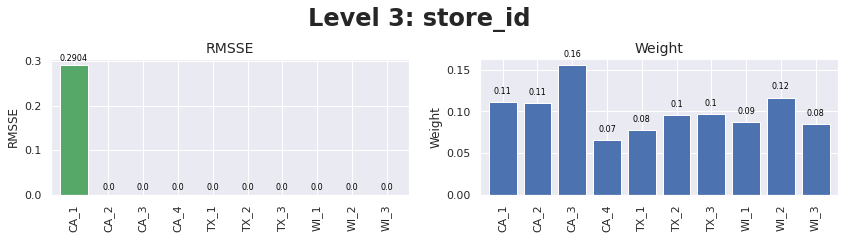

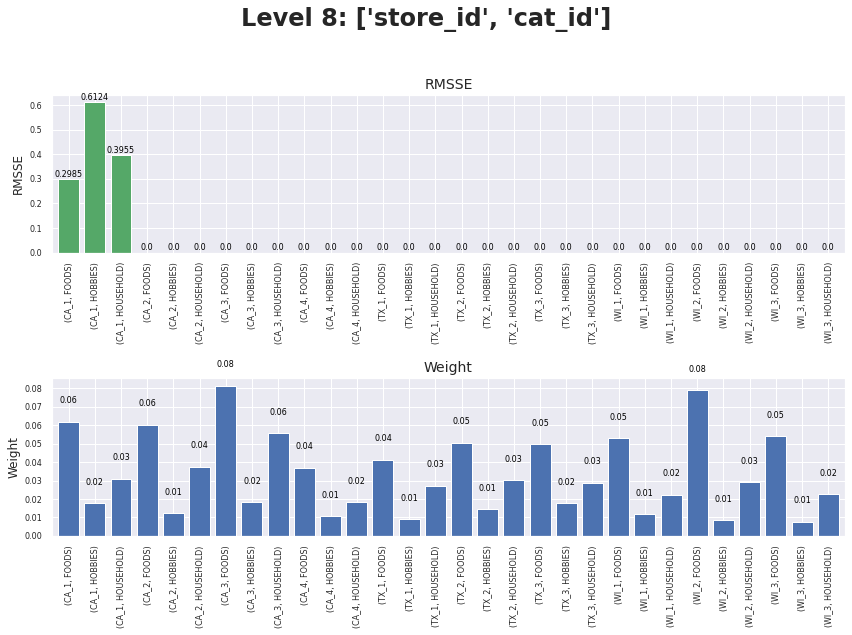

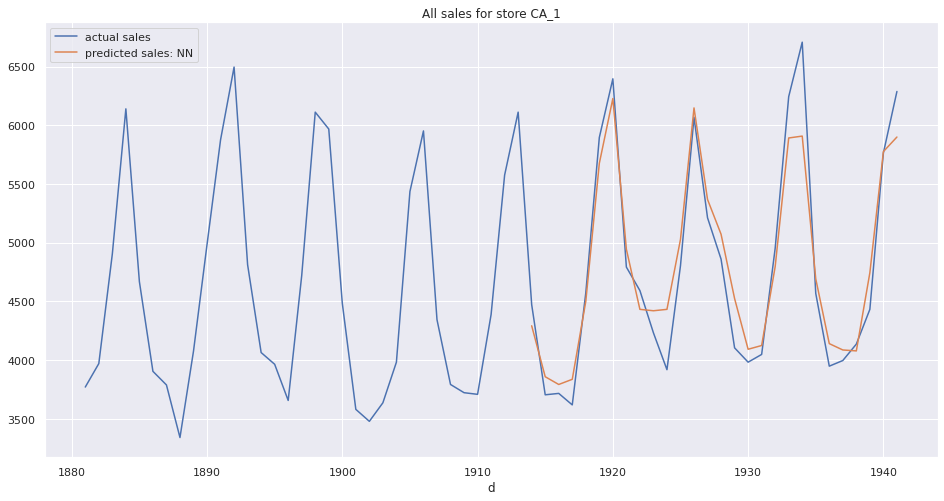

In [43]:
# select CV step that you want to display
CV_step = 1
create_dashboard(CV_step)

[back to Table of Contents](#TOC)
## 7. Conclusions <a id="Conclusions"></a>

In order to predict the whole data set (all stores), you can optimize the model for each store in an individual notebook and combine the predictions in one submission file (not implemented here). Making predictions on store level and running the different notebooks in parallel allows a quick optimization process and solves the problem with RAM limitation here on kaggle. Note that for this version neither the features nor the model have been opimized. For further ideas for FE see the references below in the comments.
